Credits: Raschka et al, Chap 11


## Building a Multi-layer Artificial Neural Network from Scratch


In [ ]:
from IPython.display import Image
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from IPython.display import display

display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/multi-layer-NN.png", width=600))

<br>
<br>



---



### Classifying handwritten digits

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [ ]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [ ]:
X = ((X / 255.) - .5) * 2

In [ ]:
print(X.shape)

(70000, 784)


In [ ]:
# to familiarize
print(np.shape(X[y == 7]))   # all digits  == 7
print(np.shape(X[y == 7][2])) # visualize second example among those with label 7

(7293, 784)
(784,)


Visualize the first digit of each class:

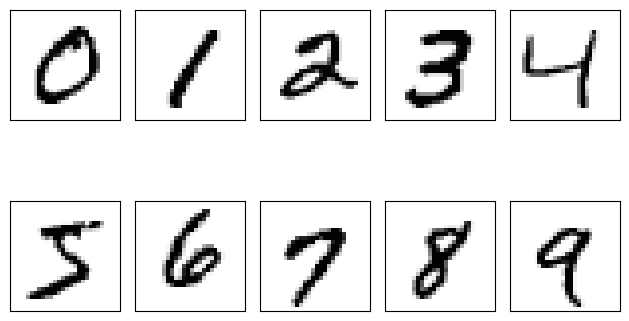

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten() #flattening the matrix of subplots
for i in range(10):
    img = X[y == i][0].reshape(28, 28) #creates a boolean mask with all images coincident with one specific digit. Of which we take the first.
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout() # Adjusts spacing
plt.show()

Visualize 25 different versions of "7":

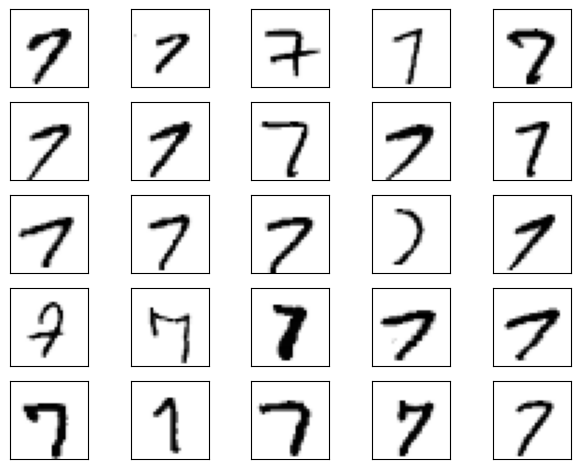

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [ ]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

<br>
<br>



---


### Modeling a Multi-Layer Perceptron (MLP)

In [ ]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))  # [n_examples, n_classes]
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class InitializeModel:
    def __init__(self, random_seed=123):
        print("Model initialization")
        self.random_seed = random_seed
        # Set up a common random number generator
        self.rng = np.random.RandomState(random_seed)
        # Common attribute for all models
        self.operation = "Initialization"


class NeuralNetMLP(InitializeModel):

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__(random_seed)


        """
        self.num_classes = num_classes

        # hidden
        #rng = np.random.RandomState(random_seed)

        self.weight_h = self.rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = self.rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        """
        self.num_classes = num_classes
        self.num_features = num_features
        self.num_hidden = num_hidden
        self._initialize_weights()


    def _initialize_weights(self):
        """Initialize weights and biases with random values."""
        # Initialize hidden layer weights and biases
        self.weight_h = self.rng.normal(
            loc=0.0, scale=0.1, size=(self.num_hidden, self.num_features))
        self.bias_h = np.zeros(self.num_hidden)

        # Initialize output layer weights and biases
        self.weight_out = self.rng.normal(
            loc=0.0, scale=0.1, size=(self.num_classes, self.num_hidden))
        self.bias_out = np.zeros(self.num_classes)

    def reinitialize(self, random_seed=None):
        """Reinitialize the model weights and biases if you need to."""
        if random_seed is not None:
            self.rng = np.random.RandomState(random_seed)
        self._initialize_weights()

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # For simplicity, the loss function is assumed to be the same we saw in Adaline, that is an MSE
        # Loss = 1/n \sum_{i=1}^{n} 1/t \sum_{j=1}^{t} (y^{i}_{j}-outa^{i}_{j})^2
        # Later on we will look at other loss functions such as multi-category cross-entropy loss

        #################################
        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutZ * dOutz/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutZ
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0) # [n_classes]


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutZ/dHiddenAct * dHiddenAct/dHiddenZ * dHiddenZ/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [ ]:
#********************************************************#
#******************     THE MODEL   *********************#
#********************************************************#

model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

#********************************************************#
#********************************************************#
#********************************************************#


Model initialization




---


### Coding the neural network training loop

Defining data loaders:

In [ ]:
num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0]) # this is the number of examples
    np.random.shuffle(indices)


    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx] # does not execute the function immediately, returs a generator object


#------------ let's check dimensionality --------------#

# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [ ]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)


predicted_labels = np.argmax(probas, axis=1) # to label take the argument corresponding to the maximum probability among the 10 predicted probabilities
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')



Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [ ]:
# Initial validation MSE: 0.3
# Initial validation accuracy: 9.4%

# do these results make sense?


In [ ]:
# at any given epoch

def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)


    # compute through mini-batches: more memory efficient

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.4f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [ ]:
np.random.seed(123) # for the training set shuffling

#model.reinitialize()

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=40, learning_rate=0.1)

Epoch: 001/040 | Train MSE: 0.0499 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/040 | Train MSE: 0.0311 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/040 | Train MSE: 0.0243 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/040 | Train MSE: 0.0208 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/040 | Train MSE: 0.0187 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/040 | Train MSE: 0.0174 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/040 | Train MSE: 0.0164 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/040 | Train MSE: 0.0155 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/040 | Train MSE: 0.0148 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/040 | Train MSE: 0.0142 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/040 | Train MSE: 0.0138 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/040 | Train MSE: 0.0134 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/040 | Train MSE: 0.0130 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/040 | Train MS



---


### Evaluating the neural network performance

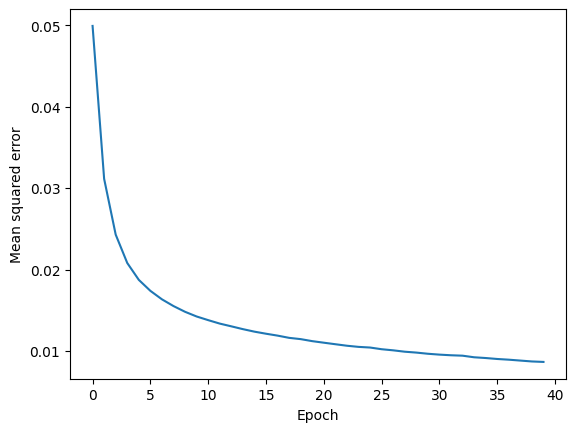

In [ ]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

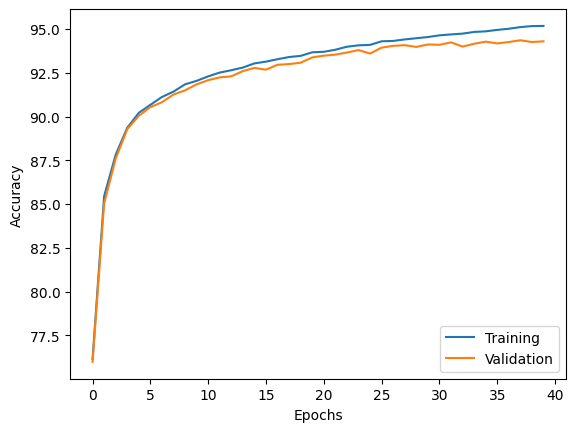

In [ ]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.13%


### Analysis of failed cases

In [ ]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

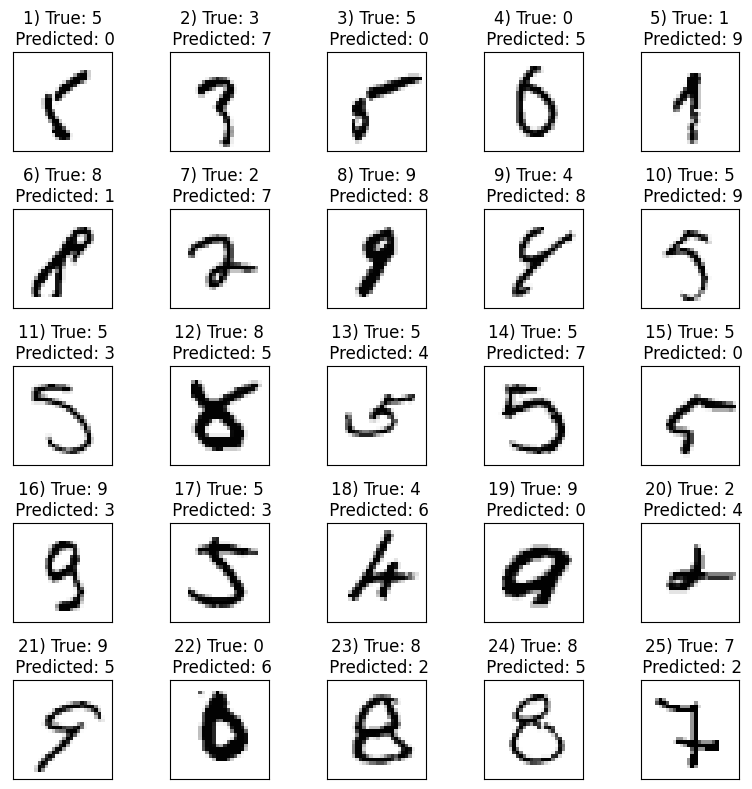

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Some of these may not look challenging, still the network fails.
For number 7, for example, we can guess that handwritten digit 7 with a horizontal line is underrepresented in our dataset and gets misclassified.  



---


### Other checks and further analysis

**Check image-level predictions**

In [ ]:
def plot_rand_digit(X,y):
    tmp_indx = np.random.randint(len(X))
    image_data = np.reshape(X[tmp_indx],(28, 28))
    plt.imshow(image_data, cmap='gray')
    plt.colorbar()
    plt.show()
    print("label is: ",y[tmp_indx])
    return image_data,X[tmp_indx]

def plot_digit(tmp_indx, X,y):
    image_data = np.reshape(X[tmp_indx],(28, 28))
    plt.imshow(image_data, cmap='gray')
    plt.colorbar()
    plt.show()
    print("label is: ",y[tmp_indx])
    return image_data,X[tmp_indx]

def plot_image(image_data):
    plt.imshow(image_data, cmap='gray')
    plt.colorbar()
    plt.show()

def image_2_X(tmp_image):
    return tmp_image.reshape(28*28,)

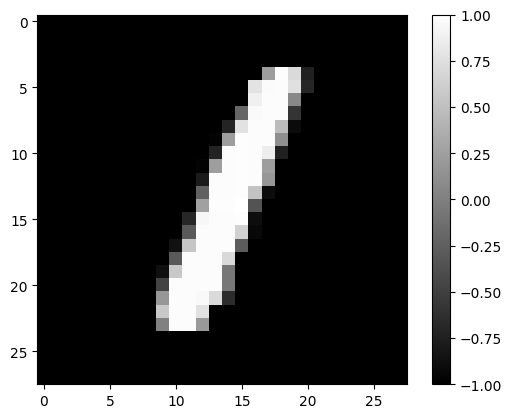

label is:  1


In [ ]:
tmp_image, tmp_imX = plot_rand_digit(X_test,y_test)

In [ ]:
# Rotate the array by 90 degrees
rotated_image = np.rot90(tmp_image)
#rotated_image = np.rot90(rotated_image)

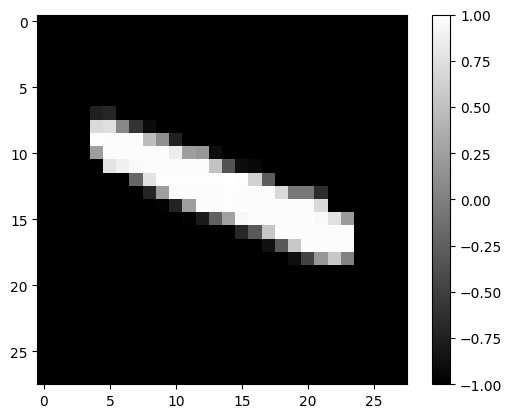

In [ ]:
plot_image(rotated_image)

In [ ]:
tmp_X = image_2_X(rotated_image)

In [ ]:
_, probas = model.forward(tmp_X)

rotated_pred = np.argmax(probas)

print("Predicted label is: ", rotated_pred)

Predicted label is:  4


**Visualize in 3D-PCA**

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.io as pio

from google.colab import files

# Save the plot as an HTML file

def plot_3d_pca(X, y, target_names=None):
    # Apply PCA with 3 components
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Combine the PCA results and target labels
    data = np.column_stack((X_pca, y))

    # Create a DataFrame with column names
    columns = ['PC1', 'PC2', 'PC3', 'label']
    df = pd.DataFrame(data, columns=columns)
    df['label'] = df['label'].astype(int)

    if target_names is not None:
        df['label_name'] = df['label'].apply(lambda x: target_names[x])
        color_col = 'label_name'
    else:
        color_col = 'label'

    # Create the interactive 3D plot
    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color=color_col, symbol=color_col, text=color_col,
                        labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'})

    # Customize the plot appearance
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
        scene=dict(
            xaxis_title='Principal Component 1',
            yaxis_title='Principal Component 2',
            zaxis_title='Principal Component 3',
        ),
    )

    # Show the plot
    #fig.show()

    pio.write_html(fig, file="3d_pca_plot.html", auto_open=True)

    files.download("3d_pca_plot.html")

    return fig

In [ ]:
fig = plot_3d_pca(X_test, y_test, ['0','1','2','3','4','5','6','7','8','9'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---

### Representation of the Weights in the Hidden Layer

In [ ]:
print(np.shape(model.weight_h))
# each row in model.weight_h represents the weights for one neuron

(50, 784)


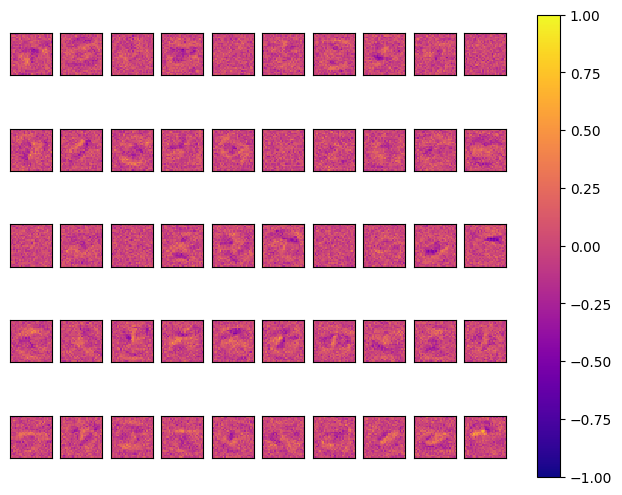

In [ ]:
plt.rcParams["figure.figsize"] = (8.0,6.0)

fig, axes = plt.subplots(5, 10)
"""
# use can global min / max to ensure all weights are shown on the same scale
vmin, vmax = model.weight_h.min(), model.weight_h.max()
max_abs = np.max([np.abs(vmin), np.abs(vmax)])
"""

for coef, ax in zip(model.weight_h, axes.ravel()):  #ravel() flattens the 2D array (5,10) into a 1D array of length 50
    #matshow is used to display a matrix as an image
    im = ax.matshow(coef.reshape(28, 28), cmap=plt.cm.plasma, vmin=-1., vmax=1.)
    ax.set_xticks(())
    ax.set_yticks(())


# Add a colorbar to the figure
cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.show()




---

### Coding

**Problem 1: Change the hidden layer activation Function to be a ReLU**

Hint:


* Forward pass

    ```
    # Hidden layer
    z_h = np.dot(x, self.weight_h.T) + self.bias_h
    a_h = np.maximum(0, z_h)  # ReLU activation
    ```

* Backward pass

    ```
    d_a_h__d_z_h = a_h * (1 - a_h) is replaced with d_a_h__d_z_h = np.where(a_h > 0, 1, 0).
    ```

    This applies the derivative of ReLU, which is 1 when a_h > 0 and 0 when a_h <= 0.




In [ ]:
##########################
### MODEL
##########################

def relu(z):
    # ::::::::::: COMPLETE :::::::::::
    return

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))  # [n_examples, n_classes]
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class InitializeModel:
    def __init__(self, random_seed=123):
        print("Model initialization")
        self.random_seed = random_seed
        # Set up a common random number generator
        self.rng = np.random.RandomState(random_seed)
        # Common attribute for all models
        self.operation = "Initialization"


class NeuralNetMLP_ReLU(InitializeModel):

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__(random_seed)


        """
        self.num_classes = num_classes

        # hidden
        #rng = np.random.RandomState(random_seed)

        self.weight_h = self.rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = self.rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        """
        self.num_classes = num_classes
        self.num_features = num_features
        self.num_hidden = num_hidden
        self._initialize_weights()


    def _initialize_weights(self):
        """Initialize weights and biases with random values."""
        # Initialize hidden layer weights and biases
        self.weight_h = self.rng.normal(
            loc=0.0, scale=0.1, size=(self.num_hidden, self.num_features))
        self.bias_h = np.zeros(self.num_hidden)

        # Initialize output layer weights and biases
        self.weight_out = self.rng.normal(
            loc=0.0, scale=0.1, size=(self.num_classes, self.num_hidden))
        self.bias_out = np.zeros(self.num_classes)

    def reinitialize(self, random_seed=None):
        """Reinitialize the model weights and biases if you need to."""
        if random_seed is not None:
            self.rng = np.random.RandomState(random_seed)
        self._initialize_weights()

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        # ::::::::::: COMPLETE :::::::::::
        a_h =  # ReLU activation

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # For simplicity, the loss function is assumed to be the same we saw in Adaline, that is an MSE
        # Loss = 1/n \sum_{i=1}^{n} 1/t \sum_{j=1}^{t} (y^{i}_{j}-outa^{i}_{j})^2
        # Later on we will look at other loss functions such as multi-category cross-entropy loss

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutZ * dOutz/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutZ
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative (<--- demonstrate)

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0) # [n_classes]


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutZ/dHiddenAct * dHiddenAct/dHiddenZ * dHiddenZ/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        # ::::::::::: COMPLETE :::::::::::
        d_a_h__d_z_h =

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [ ]:
#********************************************************#
#******************     THE MODEL   *********************#
#********************************************************#

model_relu = NeuralNetMLP_ReLU(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

#********************************************************#
#********************************************************#
#********************************************************#


Model initialization


In [ ]:
np.random.seed(123) # for the training set shuffling

#model.reinitialize()

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model_relu, X_train, y_train, X_valid, y_valid,
    num_epochs=40, learning_rate=0.1)

Epoch: 001/040 | Train MSE: 0.0206 | Train Acc: 88.81% | Valid Acc: 88.84%
Epoch: 002/040 | Train MSE: 0.0163 | Train Acc: 90.78% | Valid Acc: 90.74%
Epoch: 003/040 | Train MSE: 0.0143 | Train Acc: 91.97% | Valid Acc: 91.54%
Epoch: 004/040 | Train MSE: 0.0125 | Train Acc: 92.92% | Valid Acc: 92.72%
Epoch: 005/040 | Train MSE: 0.0117 | Train Acc: 93.40% | Valid Acc: 93.10%
Epoch: 006/040 | Train MSE: 0.0110 | Train Acc: 93.83% | Valid Acc: 93.26%
Epoch: 007/040 | Train MSE: 0.0103 | Train Acc: 94.36% | Valid Acc: 93.94%
Epoch: 008/040 | Train MSE: 0.0098 | Train Acc: 94.52% | Valid Acc: 94.08%
Epoch: 009/040 | Train MSE: 0.0091 | Train Acc: 94.91% | Valid Acc: 94.50%
Epoch: 010/040 | Train MSE: 0.0089 | Train Acc: 95.09% | Valid Acc: 94.74%
Epoch: 011/040 | Train MSE: 0.0085 | Train Acc: 95.40% | Valid Acc: 94.82%
Epoch: 012/040 | Train MSE: 0.0083 | Train Acc: 95.44% | Valid Acc: 94.82%
Epoch: 013/040 | Train MSE: 0.0078 | Train Acc: 95.75% | Valid Acc: 95.16%
Epoch: 014/040 | Train MS

In [ ]:
test_mse, test_acc = compute_mse_and_acc(model_relu, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 96.09%
